In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [7]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    next_states_logits, Qs_logits = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                        action_size=action_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits,
                                                                   labels=next_states_labels))
    #################################################### s'', Q' = env(s', a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_next_states_logits, nextQs_logits = Env(actions=next_actions_logits, states=next_states, # given
                                                 hidden_size=hidden_size, action_size=action_size, 
                                                 state_size=state_size, reuse=True)
    #################################################### s'', Q' = env(~s', ~a')
    next_actions_logits_ = Act(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
                               reuse=True)
    next_next_states_logits_, nextQs_logits_ = Env(actions=next_actions_logits_, states=next_states_logits, # pred
                                                   hidden_size=hidden_size, action_size=action_size, 
                                                   state_size=state_size, reuse=True)
    ##################################################### GAN
    Qs = tf.reshape(Qs_logits, shape=[-1])
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * (1-dones)
    nextQs_ = tf.reshape(nextQs_logits_, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs, # GAN
                                                                    labels=tf.ones_like(rates))) # max
    ######################################################### Curosity=intrinsic reward
    rloss = tf.square(nextQs-nextQs_)
    sloss = tf.reduce_sum(tf.square(next_next_states_logits-next_next_states_logits_), axis=1)
    #### Q/r loss
    mean, var = tf.nn.moments(x=rloss,axes=[0])
    std = tf.sqrt(var)
    rloss_norm = (rloss - mean)/ std 
    #### State loss
    mean, var = tf.nn.moments(x=sloss,axes=[0])
    std = tf.sqrt(var)
    sloss_norm = (sloss - mean)/ std
    #### Intrinsic_rewards
    intrinsic_rewards = sloss_norm + rloss_norm
    ########################################################## Q = r + 0.99*Q'
    targetQs = rewards + intrinsic_rewards + (gamma * nextQs)
    eloss += tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, aloss, eloss, aloss2

In [8]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [12]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [13]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [14]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:0.7207 eloss:6.2395 aloss2:0.8141 exploreP:0.9983
Episode:1 meanR:27.0000 R:37.0000 rate:0.0740 aloss:0.7100 eloss:6.3620 aloss2:0.7838 exploreP:0.9947
Episode:2 meanR:24.0000 R:18.0000 rate:0.0360 aloss:0.7077 eloss:6.1339 aloss2:0.8163 exploreP:0.9929
Episode:3 meanR:22.5000 R:18.0000 rate:0.0360 aloss:0.7098 eloss:6.3934 aloss2:0.7755 exploreP:0.9911
Episode:4 meanR:23.6000 R:28.0000 rate:0.0560 aloss:0.7056 eloss:6.4636 aloss2:0.7612 exploreP:0.9884
Episode:5 meanR:22.0000 R:14.0000 rate:0.0280 aloss:0.7035 eloss:6.4041 aloss2:0.7644 exploreP:0.9870
Episode:6 meanR:21.1429 R:16.0000 rate:0.0320 aloss:0.7030 eloss:6.3502 aloss2:0.7578 exploreP:0.9855
Episode:7 meanR:19.7500 R:10.0000 rate:0.0200 aloss:0.6894 eloss:6.2569 aloss2:0.7541 exploreP:0.9845
Episode:8 meanR:20.0000 R:22.0000 rate:0.0440 aloss:0.7039 eloss:6.3522 aloss2:0.7552 exploreP:0.9823
Episode:9 meanR:20.8000 R:28.0000 rate:0.0560 aloss:0.7014 eloss:6.4840 aloss2:0.7

Episode:80 meanR:21.6914 R:36.0000 rate:0.0720 aloss:0.6980 eloss:5.0133 aloss2:0.6563 exploreP:0.8405
Episode:81 meanR:22.0732 R:53.0000 rate:0.1060 aloss:0.7002 eloss:5.2169 aloss2:0.6593 exploreP:0.8361
Episode:82 meanR:22.0602 R:21.0000 rate:0.0420 aloss:0.7053 eloss:5.0389 aloss2:0.6557 exploreP:0.8344
Episode:83 meanR:22.3214 R:44.0000 rate:0.0880 aloss:0.7019 eloss:4.9794 aloss2:0.6538 exploreP:0.8307
Episode:84 meanR:22.1882 R:11.0000 rate:0.0220 aloss:0.7067 eloss:5.1568 aloss2:0.6570 exploreP:0.8298
Episode:85 meanR:22.1744 R:21.0000 rate:0.0420 aloss:0.7055 eloss:4.9859 aloss2:0.6579 exploreP:0.8281
Episode:86 meanR:22.1609 R:21.0000 rate:0.0420 aloss:0.7162 eloss:5.2389 aloss2:0.6622 exploreP:0.8264
Episode:87 meanR:22.0795 R:15.0000 rate:0.0300 aloss:0.7219 eloss:5.0051 aloss2:0.6704 exploreP:0.8252
Episode:88 meanR:22.0787 R:22.0000 rate:0.0440 aloss:0.6988 eloss:4.8281 aloss2:0.6565 exploreP:0.8234
Episode:89 meanR:21.9556 R:11.0000 rate:0.0220 aloss:0.7000 eloss:4.8974 

Episode:159 meanR:20.6300 R:16.0000 rate:0.0320 aloss:0.7491 eloss:5.2463 aloss2:0.6797 exploreP:0.7161
Episode:160 meanR:20.5700 R:10.0000 rate:0.0200 aloss:0.6859 eloss:4.6032 aloss2:0.6727 exploreP:0.7154
Episode:161 meanR:20.7900 R:33.0000 rate:0.0660 aloss:0.7034 eloss:4.7317 aloss2:0.6703 exploreP:0.7131
Episode:162 meanR:20.8200 R:17.0000 rate:0.0340 aloss:0.7354 eloss:4.9775 aloss2:0.6703 exploreP:0.7119
Episode:163 meanR:20.7500 R:14.0000 rate:0.0280 aloss:0.7082 eloss:4.7522 aloss2:0.6752 exploreP:0.7109
Episode:164 meanR:20.6700 R:19.0000 rate:0.0380 aloss:0.7509 eloss:4.9012 aloss2:0.6782 exploreP:0.7096
Episode:165 meanR:20.4200 R:15.0000 rate:0.0300 aloss:0.7289 eloss:5.0105 aloss2:0.6805 exploreP:0.7085
Episode:166 meanR:20.3800 R:10.0000 rate:0.0200 aloss:0.7272 eloss:4.9448 aloss2:0.6825 exploreP:0.7079
Episode:167 meanR:20.4100 R:16.0000 rate:0.0320 aloss:0.7427 eloss:5.0825 aloss2:0.6808 exploreP:0.7067
Episode:168 meanR:20.4100 R:13.0000 rate:0.0260 aloss:0.7225 elo

Episode:238 meanR:17.1400 R:12.0000 rate:0.0240 aloss:0.7162 eloss:4.7064 aloss2:0.6788 exploreP:0.6267
Episode:239 meanR:17.1300 R:12.0000 rate:0.0240 aloss:0.7279 eloss:4.8964 aloss2:0.6824 exploreP:0.6259
Episode:240 meanR:17.1100 R:17.0000 rate:0.0340 aloss:0.7331 eloss:4.9317 aloss2:0.6845 exploreP:0.6249
Episode:241 meanR:17.1600 R:20.0000 rate:0.0400 aloss:0.7342 eloss:4.8251 aloss2:0.6806 exploreP:0.6236
Episode:242 meanR:17.0700 R:15.0000 rate:0.0300 aloss:0.7268 eloss:4.9556 aloss2:0.6817 exploreP:0.6227
Episode:243 meanR:17.0900 R:15.0000 rate:0.0300 aloss:0.7301 eloss:4.6767 aloss2:0.6796 exploreP:0.6218
Episode:244 meanR:17.0500 R:16.0000 rate:0.0320 aloss:0.7218 eloss:4.8253 aloss2:0.6885 exploreP:0.6208
Episode:245 meanR:17.2300 R:32.0000 rate:0.0640 aloss:0.7210 eloss:4.6950 aloss2:0.6815 exploreP:0.6189
Episode:246 meanR:17.2500 R:25.0000 rate:0.0500 aloss:0.7246 eloss:4.7618 aloss2:0.6855 exploreP:0.6173
Episode:247 meanR:17.2800 R:15.0000 rate:0.0300 aloss:0.7538 elo

Episode:317 meanR:15.3900 R:15.0000 rate:0.0300 aloss:0.7559 eloss:4.8418 aloss2:0.6788 exploreP:0.5569
Episode:318 meanR:15.4200 R:13.0000 rate:0.0260 aloss:0.7769 eloss:4.8763 aloss2:0.6816 exploreP:0.5562
Episode:319 meanR:15.4600 R:17.0000 rate:0.0340 aloss:0.7321 eloss:4.7658 aloss2:0.6834 exploreP:0.5552
Episode:320 meanR:15.4600 R:11.0000 rate:0.0220 aloss:0.7438 eloss:4.8005 aloss2:0.6863 exploreP:0.5546
Episode:321 meanR:15.5400 R:19.0000 rate:0.0380 aloss:0.7069 eloss:4.7233 aloss2:0.6882 exploreP:0.5536
Episode:322 meanR:15.4300 R:11.0000 rate:0.0220 aloss:0.7042 eloss:4.5817 aloss2:0.6821 exploreP:0.5530
Episode:323 meanR:15.4400 R:19.0000 rate:0.0380 aloss:0.7296 eloss:4.7301 aloss2:0.6854 exploreP:0.5520
Episode:324 meanR:15.3900 R:16.0000 rate:0.0320 aloss:0.7549 eloss:4.8934 aloss2:0.6862 exploreP:0.5511
Episode:325 meanR:15.3100 R:10.0000 rate:0.0200 aloss:0.7570 eloss:4.7425 aloss2:0.6838 exploreP:0.5506
Episode:326 meanR:15.3400 R:15.0000 rate:0.0300 aloss:0.7651 elo

Episode:396 meanR:21.4000 R:31.0000 rate:0.0620 aloss:0.6808 eloss:4.7066 aloss2:0.6752 exploreP:0.4654
Episode:397 meanR:21.8100 R:51.0000 rate:0.1020 aloss:0.6904 eloss:4.8868 aloss2:0.6734 exploreP:0.4631
Episode:398 meanR:22.4600 R:75.0000 rate:0.1500 aloss:0.6923 eloss:4.9582 aloss2:0.6731 exploreP:0.4597
Episode:399 meanR:22.8500 R:50.0000 rate:0.1000 aloss:0.6899 eloss:4.9605 aloss2:0.6724 exploreP:0.4574
Episode:400 meanR:23.1100 R:41.0000 rate:0.0820 aloss:0.6904 eloss:4.9893 aloss2:0.6709 exploreP:0.4556
Episode:401 meanR:23.4800 R:48.0000 rate:0.0960 aloss:0.6884 eloss:4.9351 aloss2:0.6707 exploreP:0.4535
Episode:402 meanR:23.6700 R:32.0000 rate:0.0640 aloss:0.7025 eloss:5.1557 aloss2:0.6709 exploreP:0.4520
Episode:403 meanR:24.1000 R:56.0000 rate:0.1120 aloss:0.7080 eloss:5.1356 aloss2:0.6688 exploreP:0.4496
Episode:404 meanR:24.3600 R:38.0000 rate:0.0760 aloss:0.7012 eloss:5.0836 aloss2:0.6713 exploreP:0.4479
Episode:405 meanR:24.8700 R:64.0000 rate:0.1280 aloss:0.6867 elo

Episode:475 meanR:29.1900 R:13.0000 rate:0.0260 aloss:0.7017 eloss:4.4652 aloss2:0.6809 exploreP:0.3827
Episode:476 meanR:29.1500 R:20.0000 rate:0.0400 aloss:0.7221 eloss:4.5601 aloss2:0.6796 exploreP:0.3819
Episode:477 meanR:29.0300 R:13.0000 rate:0.0260 aloss:0.7219 eloss:4.4931 aloss2:0.6794 exploreP:0.3814
Episode:478 meanR:28.7900 R:13.0000 rate:0.0260 aloss:0.7246 eloss:4.7607 aloss2:0.6804 exploreP:0.3810
Episode:479 meanR:28.6600 R:19.0000 rate:0.0380 aloss:0.7475 eloss:4.5185 aloss2:0.6787 exploreP:0.3803
Episode:480 meanR:28.4500 R:14.0000 rate:0.0280 aloss:0.7337 eloss:4.4540 aloss2:0.6803 exploreP:0.3797
Episode:481 meanR:28.2000 R:12.0000 rate:0.0240 aloss:0.7162 eloss:4.4273 aloss2:0.6814 exploreP:0.3793
Episode:482 meanR:28.1700 R:12.0000 rate:0.0240 aloss:0.7083 eloss:4.4209 aloss2:0.6809 exploreP:0.3789
Episode:483 meanR:27.6100 R:11.0000 rate:0.0220 aloss:0.7133 eloss:4.4488 aloss2:0.6809 exploreP:0.3784
Episode:484 meanR:27.1100 R:17.0000 rate:0.0340 aloss:0.7297 elo

Episode:554 meanR:13.4100 R:13.0000 rate:0.0260 aloss:0.7476 eloss:4.5705 aloss2:0.6863 exploreP:0.3474
Episode:555 meanR:13.3300 R:8.0000 rate:0.0160 aloss:0.7061 eloss:4.2521 aloss2:0.6872 exploreP:0.3471
Episode:556 meanR:13.1900 R:10.0000 rate:0.0200 aloss:0.7897 eloss:4.5553 aloss2:0.6802 exploreP:0.3468
Episode:557 meanR:13.1300 R:12.0000 rate:0.0240 aloss:0.7442 eloss:4.5741 aloss2:0.6833 exploreP:0.3464
Episode:558 meanR:13.0800 R:12.0000 rate:0.0240 aloss:0.7554 eloss:4.7695 aloss2:0.6756 exploreP:0.3460
Episode:559 meanR:13.0500 R:12.0000 rate:0.0240 aloss:0.7557 eloss:5.1314 aloss2:0.6696 exploreP:0.3456
Episode:560 meanR:12.9400 R:10.0000 rate:0.0200 aloss:0.8589 eloss:5.4148 aloss2:0.6661 exploreP:0.3452
Episode:561 meanR:12.8500 R:9.0000 rate:0.0180 aloss:0.8046 eloss:5.4245 aloss2:0.6566 exploreP:0.3449
Episode:562 meanR:12.7500 R:11.0000 rate:0.0220 aloss:0.8442 eloss:5.2497 aloss2:0.6358 exploreP:0.3446
Episode:563 meanR:12.7700 R:16.0000 rate:0.0320 aloss:0.8767 eloss

Episode:633 meanR:11.2000 R:11.0000 rate:0.0220 aloss:0.9837 eloss:5.3817 aloss2:0.5613 exploreP:0.3189
Episode:634 meanR:11.2000 R:10.0000 rate:0.0200 aloss:0.9566 eloss:5.3800 aloss2:0.5668 exploreP:0.3186
Episode:635 meanR:11.1800 R:9.0000 rate:0.0180 aloss:1.0986 eloss:5.6556 aloss2:0.5548 exploreP:0.3183
Episode:636 meanR:11.1600 R:11.0000 rate:0.0220 aloss:1.0527 eloss:6.0059 aloss2:0.5897 exploreP:0.3180
Episode:637 meanR:11.1200 R:11.0000 rate:0.0220 aloss:1.0380 eloss:5.5001 aloss2:0.5612 exploreP:0.3176
Episode:638 meanR:11.0900 R:11.0000 rate:0.0220 aloss:1.0897 eloss:5.6584 aloss2:0.5665 exploreP:0.3173
Episode:639 meanR:11.1300 R:13.0000 rate:0.0260 aloss:1.0578 eloss:5.5482 aloss2:0.5700 exploreP:0.3169
Episode:640 meanR:11.1500 R:11.0000 rate:0.0220 aloss:1.0785 eloss:5.5309 aloss2:0.5652 exploreP:0.3166
Episode:641 meanR:11.1300 R:10.0000 rate:0.0200 aloss:0.9964 eloss:5.3897 aloss2:0.5806 exploreP:0.3163
Episode:642 meanR:11.1400 R:11.0000 rate:0.0220 aloss:1.1284 elos

Episode:712 meanR:11.6400 R:10.0000 rate:0.0200 aloss:1.1184 eloss:4.9194 aloss2:0.6938 exploreP:0.2914
Episode:713 meanR:11.6200 R:10.0000 rate:0.0200 aloss:0.9475 eloss:4.6904 aloss2:0.6969 exploreP:0.2911
Episode:714 meanR:11.6000 R:9.0000 rate:0.0180 aloss:1.0433 eloss:4.8929 aloss2:0.6991 exploreP:0.2908
Episode:715 meanR:11.5900 R:10.0000 rate:0.0200 aloss:1.0526 eloss:5.1238 aloss2:0.7097 exploreP:0.2905
Episode:716 meanR:11.5800 R:13.0000 rate:0.0260 aloss:1.1089 eloss:4.9473 aloss2:0.6986 exploreP:0.2902
Episode:717 meanR:11.5900 R:9.0000 rate:0.0180 aloss:0.9970 eloss:4.7322 aloss2:0.7072 exploreP:0.2899
Episode:718 meanR:11.5400 R:11.0000 rate:0.0220 aloss:1.0931 eloss:4.8176 aloss2:0.6966 exploreP:0.2896
Episode:719 meanR:11.5500 R:11.0000 rate:0.0220 aloss:0.9620 eloss:4.5874 aloss2:0.7048 exploreP:0.2893
Episode:720 meanR:11.5500 R:9.0000 rate:0.0180 aloss:1.0964 eloss:4.9309 aloss2:0.7103 exploreP:0.2891
Episode:721 meanR:11.6000 R:13.0000 rate:0.0260 aloss:1.1597 eloss:

Episode:792 meanR:11.0800 R:9.0000 rate:0.0180 aloss:1.0173 eloss:4.0388 aloss2:0.9031 exploreP:0.2675
Episode:793 meanR:11.0700 R:11.0000 rate:0.0220 aloss:1.1651 eloss:4.1320 aloss2:0.9140 exploreP:0.2672
Episode:794 meanR:11.0800 R:10.0000 rate:0.0200 aloss:0.9286 eloss:3.8157 aloss2:0.8979 exploreP:0.2670
Episode:795 meanR:11.1000 R:12.0000 rate:0.0240 aloss:0.9920 eloss:3.8377 aloss2:0.9070 exploreP:0.2667
Episode:796 meanR:11.1000 R:11.0000 rate:0.0220 aloss:1.0423 eloss:3.7910 aloss2:0.9033 exploreP:0.2664
Episode:797 meanR:11.1100 R:12.0000 rate:0.0240 aloss:1.0367 eloss:3.8836 aloss2:0.9152 exploreP:0.2661
Episode:798 meanR:11.1100 R:10.0000 rate:0.0200 aloss:0.9220 eloss:3.6797 aloss2:0.9030 exploreP:0.2658
Episode:799 meanR:11.1300 R:11.0000 rate:0.0220 aloss:1.0090 eloss:3.6922 aloss2:0.9107 exploreP:0.2655
Episode:800 meanR:11.1800 R:13.0000 rate:0.0260 aloss:1.0317 eloss:3.8057 aloss2:0.9154 exploreP:0.2652
Episode:801 meanR:11.1500 R:10.0000 rate:0.0200 aloss:1.0745 elos

Episode:871 meanR:10.7400 R:14.0000 rate:0.0280 aloss:0.9152 eloss:3.3100 aloss2:1.0869 exploreP:0.2465
Episode:872 meanR:10.7500 R:9.0000 rate:0.0180 aloss:0.9377 eloss:3.3775 aloss2:1.0872 exploreP:0.2463
Episode:873 meanR:10.7300 R:9.0000 rate:0.0180 aloss:0.8839 eloss:3.2438 aloss2:1.0801 exploreP:0.2461
Episode:874 meanR:10.7900 R:15.0000 rate:0.0300 aloss:0.9084 eloss:3.3100 aloss2:1.0927 exploreP:0.2458
Episode:875 meanR:10.7700 R:9.0000 rate:0.0180 aloss:0.9515 eloss:3.3797 aloss2:1.1048 exploreP:0.2455
Episode:876 meanR:10.7600 R:10.0000 rate:0.0200 aloss:0.8713 eloss:3.4357 aloss2:1.0951 exploreP:0.2453
Episode:877 meanR:10.7900 R:11.0000 rate:0.0220 aloss:0.9446 eloss:3.3436 aloss2:1.1062 exploreP:0.2451
Episode:878 meanR:10.8000 R:10.0000 rate:0.0200 aloss:0.8592 eloss:3.2404 aloss2:1.0981 exploreP:0.2448
Episode:879 meanR:10.8200 R:16.0000 rate:0.0320 aloss:0.8793 eloss:3.3867 aloss2:1.0945 exploreP:0.2444
Episode:880 meanR:10.8600 R:15.0000 rate:0.0300 aloss:0.9889 eloss:

Episode:950 meanR:20.7300 R:9.0000 rate:0.0180 aloss:0.7988 eloss:3.9429 aloss2:1.0998 exploreP:0.2067
Episode:951 meanR:20.7300 R:11.0000 rate:0.0220 aloss:0.7848 eloss:3.6241 aloss2:1.0976 exploreP:0.2064
Episode:952 meanR:20.7400 R:13.0000 rate:0.0260 aloss:0.7064 eloss:3.4026 aloss2:1.0966 exploreP:0.2062
Episode:953 meanR:20.7700 R:12.0000 rate:0.0240 aloss:0.7943 eloss:3.6354 aloss2:1.0988 exploreP:0.2060
Episode:954 meanR:20.8400 R:16.0000 rate:0.0320 aloss:0.7585 eloss:3.3533 aloss2:1.1003 exploreP:0.2056
Episode:955 meanR:20.8400 R:11.0000 rate:0.0220 aloss:0.7952 eloss:3.9105 aloss2:1.1041 exploreP:0.2054
Episode:956 meanR:20.8200 R:12.0000 rate:0.0240 aloss:0.8393 eloss:3.5603 aloss2:1.0949 exploreP:0.2052
Episode:957 meanR:20.8700 R:17.0000 rate:0.0340 aloss:0.7646 eloss:3.5531 aloss2:1.0974 exploreP:0.2049
Episode:958 meanR:20.9100 R:12.0000 rate:0.0240 aloss:0.7360 eloss:3.3681 aloss2:1.1047 exploreP:0.2046
Episode:959 meanR:20.9600 R:15.0000 rate:0.0300 aloss:0.7377 elos

Episode:1029 meanR:12.4900 R:9.0000 rate:0.0180 aloss:0.7780 eloss:2.9308 aloss2:1.1745 exploreP:0.1896
Episode:1030 meanR:12.4000 R:9.0000 rate:0.0180 aloss:0.8410 eloss:3.3046 aloss2:1.1666 exploreP:0.1895
Episode:1031 meanR:12.3300 R:9.0000 rate:0.0180 aloss:0.7445 eloss:2.9232 aloss2:1.1744 exploreP:0.1893
Episode:1032 meanR:12.2000 R:9.0000 rate:0.0180 aloss:0.7401 eloss:3.3292 aloss2:1.1966 exploreP:0.1892
Episode:1033 meanR:12.1800 R:13.0000 rate:0.0260 aloss:0.9272 eloss:3.1240 aloss2:1.1765 exploreP:0.1889
Episode:1034 meanR:12.0800 R:11.0000 rate:0.0220 aloss:0.7848 eloss:2.8934 aloss2:1.1788 exploreP:0.1887
Episode:1035 meanR:12.0600 R:11.0000 rate:0.0220 aloss:0.7231 eloss:2.9887 aloss2:1.1874 exploreP:0.1885
Episode:1036 meanR:12.0500 R:17.0000 rate:0.0340 aloss:0.8757 eloss:3.0213 aloss2:1.1829 exploreP:0.1882
Episode:1037 meanR:11.9600 R:10.0000 rate:0.0200 aloss:1.0130 eloss:3.2250 aloss2:1.1774 exploreP:0.1881
Episode:1038 meanR:11.8700 R:10.0000 rate:0.0200 aloss:0.72

Episode:1108 meanR:18.6100 R:40.0000 rate:0.0800 aloss:0.8915 eloss:3.1896 aloss2:1.2569 exploreP:0.1625
Episode:1109 meanR:18.9200 R:44.0000 rate:0.0880 aloss:0.8966 eloss:3.1113 aloss2:1.2580 exploreP:0.1619
Episode:1110 meanR:19.6200 R:79.0000 rate:0.1580 aloss:0.8419 eloss:2.9514 aloss2:1.2509 exploreP:0.1607
Episode:1111 meanR:20.1600 R:66.0000 rate:0.1320 aloss:0.8333 eloss:2.9915 aloss2:1.2504 exploreP:0.1597
Episode:1112 meanR:20.4900 R:41.0000 rate:0.0820 aloss:0.8059 eloss:2.9069 aloss2:1.2482 exploreP:0.1591
Episode:1113 meanR:20.7200 R:35.0000 rate:0.0700 aloss:0.8474 eloss:2.8994 aloss2:1.2627 exploreP:0.1585
Episode:1114 meanR:21.1400 R:51.0000 rate:0.1020 aloss:0.8160 eloss:2.8628 aloss2:1.2649 exploreP:0.1578
Episode:1115 meanR:21.4800 R:43.0000 rate:0.0860 aloss:0.8537 eloss:2.9335 aloss2:1.2771 exploreP:0.1571
Episode:1116 meanR:21.8300 R:45.0000 rate:0.0900 aloss:0.8287 eloss:2.8724 aloss2:1.2712 exploreP:0.1565
Episode:1117 meanR:22.3600 R:65.0000 rate:0.1300 aloss:

Episode:1186 meanR:160.0300 R:500.0000 rate:1.0000 aloss:0.7358 eloss:2.5816 aloss2:1.7157 exploreP:0.0441
Episode:1187 meanR:164.9000 R:500.0000 rate:1.0000 aloss:0.7290 eloss:2.6213 aloss2:1.7182 exploreP:0.0424
Episode:1188 meanR:169.6800 R:500.0000 rate:1.0000 aloss:0.7418 eloss:2.6001 aloss2:1.6984 exploreP:0.0408
Episode:1189 meanR:174.5600 R:500.0000 rate:1.0000 aloss:0.7286 eloss:2.6224 aloss2:1.7037 exploreP:0.0393
Episode:1190 meanR:179.3700 R:500.0000 rate:1.0000 aloss:0.7376 eloss:2.6524 aloss2:1.6961 exploreP:0.0379
Episode:1191 meanR:184.1400 R:500.0000 rate:1.0000 aloss:0.7457 eloss:2.5989 aloss2:1.6824 exploreP:0.0365
Episode:1192 meanR:188.8300 R:500.0000 rate:1.0000 aloss:0.7394 eloss:2.6223 aloss2:1.6901 exploreP:0.0352
Episode:1193 meanR:193.4800 R:500.0000 rate:1.0000 aloss:0.7513 eloss:2.6243 aloss2:1.6776 exploreP:0.0340
Episode:1194 meanR:198.1700 R:500.0000 rate:1.0000 aloss:0.7391 eloss:2.6575 aloss2:1.6803 exploreP:0.0328
Episode:1195 meanR:202.9100 R:500.000

Episode:1263 meanR:311.0700 R:500.0000 rate:1.0000 aloss:0.6734 eloss:2.7269 aloss2:1.4539 exploreP:0.0136
Episode:1264 meanR:311.6800 R:149.0000 rate:0.2980 aloss:0.6703 eloss:2.7219 aloss2:1.4490 exploreP:0.0136
Episode:1265 meanR:313.3100 R:237.0000 rate:0.4740 aloss:0.6840 eloss:2.7109 aloss2:1.4621 exploreP:0.0135
Episode:1266 meanR:313.1100 R:250.0000 rate:0.5000 aloss:0.6721 eloss:2.8061 aloss2:1.4466 exploreP:0.0134
Episode:1267 meanR:316.1000 R:396.0000 rate:0.7920 aloss:0.6715 eloss:2.7317 aloss2:1.4536 exploreP:0.0133
Episode:1268 meanR:319.9500 R:471.0000 rate:0.9420 aloss:0.6680 eloss:2.7494 aloss2:1.4584 exploreP:0.0131
Episode:1269 meanR:323.7100 R:500.0000 rate:1.0000 aloss:0.6632 eloss:2.7603 aloss2:1.4516 exploreP:0.0130
Episode:1270 meanR:323.9900 R:402.0000 rate:0.8040 aloss:0.6663 eloss:2.7441 aloss2:1.4560 exploreP:0.0128
Episode:1271 meanR:323.6500 R:331.0000 rate:0.6620 aloss:0.6696 eloss:2.7934 aloss2:1.4348 exploreP:0.0127
Episode:1272 meanR:323.6700 R:213.000

Episode:1340 meanR:239.0900 R:148.0000 rate:0.2960 aloss:0.6487 eloss:2.9558 aloss2:1.4016 exploreP:0.0106
Episode:1341 meanR:236.8300 R:62.0000 rate:0.1240 aloss:0.6393 eloss:3.0046 aloss2:1.4027 exploreP:0.0106
Episode:1342 meanR:238.7500 R:500.0000 rate:1.0000 aloss:0.6247 eloss:2.9599 aloss2:1.4096 exploreP:0.0105
Episode:1343 meanR:235.3000 R:68.0000 rate:0.1360 aloss:0.6248 eloss:2.9786 aloss2:1.4011 exploreP:0.0105
Episode:1344 meanR:239.2200 R:500.0000 rate:1.0000 aloss:0.6389 eloss:2.9364 aloss2:1.4074 exploreP:0.0105
Episode:1345 meanR:238.9500 R:88.0000 rate:0.1760 aloss:0.5979 eloss:3.0439 aloss2:1.3992 exploreP:0.0105
Episode:1346 meanR:242.5500 R:500.0000 rate:1.0000 aloss:0.6194 eloss:2.9845 aloss2:1.4009 exploreP:0.0105
Episode:1347 meanR:246.3200 R:500.0000 rate:1.0000 aloss:0.6397 eloss:2.9625 aloss2:1.3868 exploreP:0.0104
Episode:1348 meanR:246.6100 R:108.0000 rate:0.2160 aloss:0.6410 eloss:2.8946 aloss2:1.3890 exploreP:0.0104
Episode:1349 meanR:246.7600 R:90.0000 ra

Episode:1417 meanR:252.6200 R:85.0000 rate:0.1700 aloss:0.5427 eloss:2.9749 aloss2:1.2758 exploreP:0.0101
Episode:1418 meanR:252.6500 R:69.0000 rate:0.1380 aloss:0.5284 eloss:3.0378 aloss2:1.2668 exploreP:0.0101
Episode:1419 meanR:248.2000 R:55.0000 rate:0.1100 aloss:0.4897 eloss:3.0011 aloss2:1.2772 exploreP:0.0101
Episode:1420 meanR:245.6900 R:67.0000 rate:0.1340 aloss:0.5505 eloss:3.0114 aloss2:1.2715 exploreP:0.0101
Episode:1421 meanR:249.9800 R:500.0000 rate:1.0000 aloss:0.5380 eloss:3.0052 aloss2:1.2653 exploreP:0.0101
Episode:1422 meanR:250.2700 R:78.0000 rate:0.1560 aloss:0.5609 eloss:3.0101 aloss2:1.2601 exploreP:0.0101
Episode:1423 meanR:254.7500 R:500.0000 rate:1.0000 aloss:0.5440 eloss:3.0080 aloss2:1.2697 exploreP:0.0101
Episode:1424 meanR:254.4900 R:46.0000 rate:0.0920 aloss:0.5559 eloss:3.0364 aloss2:1.2583 exploreP:0.0101
Episode:1425 meanR:254.4900 R:500.0000 rate:1.0000 aloss:0.5481 eloss:3.0251 aloss2:1.2680 exploreP:0.0101
Episode:1426 meanR:258.5100 R:500.0000 rate

Episode:1494 meanR:255.7000 R:204.0000 rate:0.4080 aloss:0.4455 eloss:2.8825 aloss2:1.0223 exploreP:0.0100
Episode:1495 meanR:259.9900 R:500.0000 rate:1.0000 aloss:0.4717 eloss:2.8860 aloss2:1.0189 exploreP:0.0100
Episode:1496 meanR:259.9900 R:500.0000 rate:1.0000 aloss:0.4517 eloss:2.8823 aloss2:1.0122 exploreP:0.0100
Episode:1497 meanR:264.4900 R:500.0000 rate:1.0000 aloss:0.4586 eloss:2.8957 aloss2:1.0145 exploreP:0.0100
Episode:1498 meanR:266.3600 R:254.0000 rate:0.5080 aloss:0.4576 eloss:2.9182 aloss2:1.0083 exploreP:0.0100
Episode:1499 meanR:270.0400 R:500.0000 rate:1.0000 aloss:0.4558 eloss:2.8999 aloss2:1.0077 exploreP:0.0100
Episode:1500 meanR:270.0400 R:500.0000 rate:1.0000 aloss:0.4404 eloss:2.8877 aloss2:1.0021 exploreP:0.0100
Episode:1501 meanR:272.9500 R:500.0000 rate:1.0000 aloss:0.4453 eloss:2.8794 aloss2:0.9992 exploreP:0.0100
Episode:1502 meanR:275.3700 R:500.0000 rate:1.0000 aloss:0.4499 eloss:2.8714 aloss2:0.9942 exploreP:0.0100
Episode:1503 meanR:279.5800 R:500.000

Episode:1571 meanR:398.3300 R:500.0000 rate:1.0000 aloss:0.4961 eloss:2.7014 aloss2:0.9157 exploreP:0.0100
Episode:1572 meanR:398.4600 R:500.0000 rate:1.0000 aloss:0.4879 eloss:2.7065 aloss2:0.9085 exploreP:0.0100
Episode:1573 meanR:398.4600 R:500.0000 rate:1.0000 aloss:0.4689 eloss:2.6893 aloss2:0.8999 exploreP:0.0100
Episode:1574 meanR:402.5900 R:500.0000 rate:1.0000 aloss:0.4502 eloss:2.7062 aloss2:0.8730 exploreP:0.0100
Episode:1575 meanR:402.5900 R:500.0000 rate:1.0000 aloss:0.4480 eloss:2.7179 aloss2:0.8616 exploreP:0.0100
Episode:1576 meanR:403.6800 R:500.0000 rate:1.0000 aloss:0.4608 eloss:2.7036 aloss2:0.8646 exploreP:0.0100
Episode:1577 meanR:403.6800 R:500.0000 rate:1.0000 aloss:0.4645 eloss:2.6889 aloss2:0.8796 exploreP:0.0100
Episode:1578 meanR:405.3700 R:500.0000 rate:1.0000 aloss:0.4483 eloss:2.6908 aloss2:0.8900 exploreP:0.0100
Episode:1579 meanR:408.2800 R:500.0000 rate:1.0000 aloss:0.4835 eloss:2.6596 aloss2:0.9277 exploreP:0.0100
Episode:1580 meanR:408.2900 R:500.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

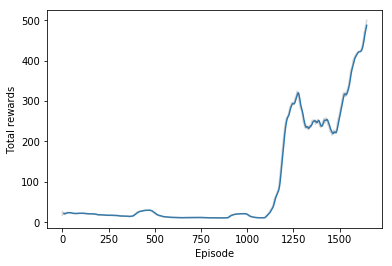

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

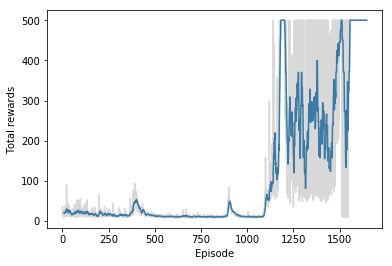

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

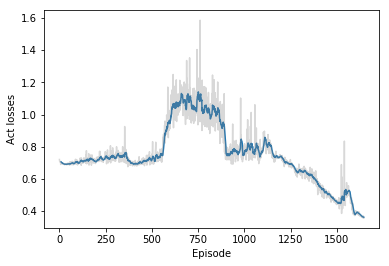

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

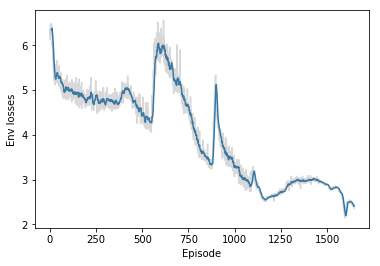

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

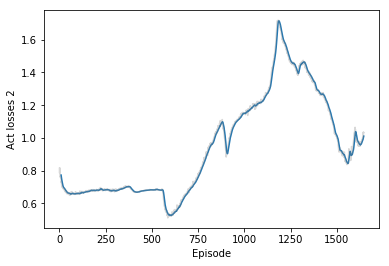

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
